In [321]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
from scipy.stats import norm
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2
from contextlib import suppress
import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns
import sys
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from sklearn import preprocessing
from sklearn import preprocessing


#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT
from functions_pmrs import calc_performance_scores_new


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]
#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
# dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

#select this next one for full period data string (whole DSMP period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns)

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-322-4b2263d88d4b>:53: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: F

In [752]:
#setting some values and calculating the CM ratio from the scripts
shift= 15 
rollingvalue = 6
selection= 12 # < number of months to be choosen
plot = 0

df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)
df.POI1.fillna(1, inplace=True)
df.POI4.fillna(1, inplace=True)

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


Text(0.5, 0, 'C/M ratio synthetic [-]')

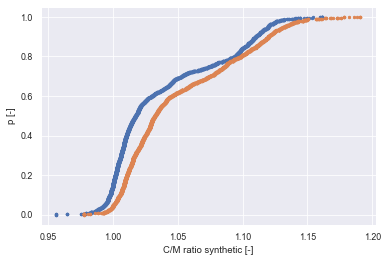

In [753]:
#setting the scene, calculating the probabilty
samples_Senanga_POI4 = df.POI4
samples_Senanga_POI1 = df.POI1


p = np.linspace(1./(1+len(df.POI4)), 1-(1./(1+len(df.POI4))), len(df.POI4))

plt.plot(np.sort(samples_Senanga_POI4), p, '.')
plt.ylabel('p [-]')
plt.xlabel('C/M ratio synthetic [-]')

plt.plot(np.sort(samples_Senanga_POI1), p, '.')
plt.ylabel('p [-]')
plt.xlabel('C/M ratio synthetic [-]')

# plt.plot(np.sort(samples_Senanga_POI4), np.sort(samples_Senanga_POI1), '.')
# plt.ylabel('C/M ratio synthetic [-]')
# plt.xlabel('C/M ratio synthetic [-]')



Text(0, 0.5, 'C/M ratio [-]')

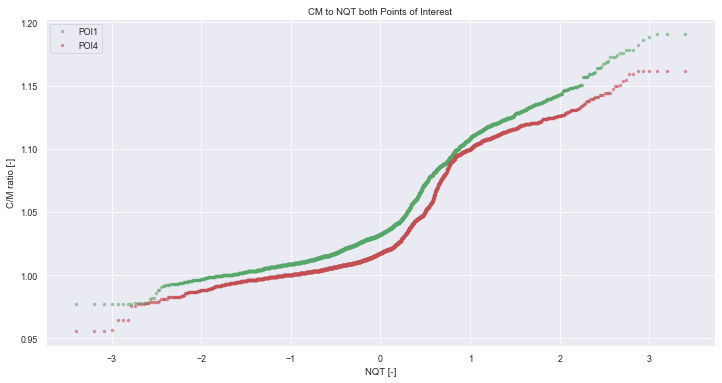

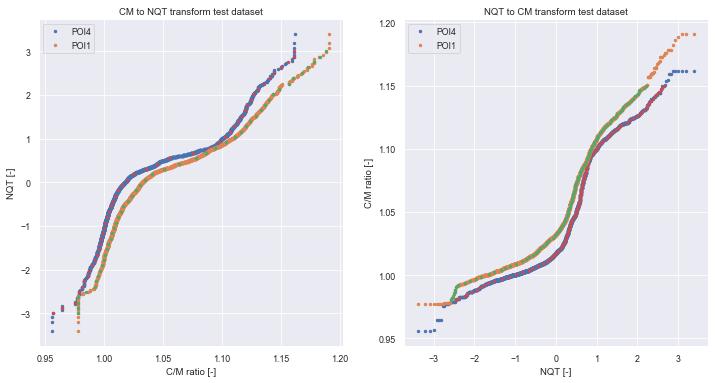

In [754]:
#Transforming to the Gausian domain and back


nqt_Senanga = norm.ppf(p)
plt.figure(figsize=(12,6))

plt.plot(nqt_Senanga,np.sort(samples_Senanga_POI1),'g.',alpha =0.5, label = 'POI1')
plt.plot(nqt_Senanga,np.sort(samples_Senanga_POI4),'r.',alpha =0.5, label = 'POI4')
plt.title('CM to NQT both Points of Interest')
plt.legend()
plt.xlabel('NQT [-]')
plt.ylabel('C/M ratio [-]')




#---- NQT TO CM

mapping_nqt_to_cm_POI4 = interp.interp1d(nqt_Senanga, np.sort(samples_Senanga_POI4))
mapping_nqt_to_cm_POI1 = interp.interp1d(nqt_Senanga, np.sort(samples_Senanga_POI1))


new_nqt_values= np.linspace(-3, 3, 50)

cm_mapped_POI4 = mapping_nqt_to_cm_POI4(new_nqt_values)
cm_mapped_POI1 = mapping_nqt_to_cm_POI1(new_nqt_values)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(np.sort(samples_Senanga_POI4),nqt_Senanga , '.', label = 'POI4')  
plt.plot(cm_mapped_POI4, new_nqt_values, 'r.')
plt.plot(np.sort(samples_Senanga_POI1),nqt_Senanga , '.', label = 'POI1') 
plt.legend()
plt.plot(cm_mapped_POI1, new_nqt_values, 'g.')
plt.title('CM to NQT transform test dataset')

plt.ylabel('NQT [-]')
plt.xlabel('C/M ratio [-]')

#--- CM TO NQT
mapping_cm_to_nqt_POI4 = interp.interp1d(np.sort(samples_Senanga_POI4), nqt_Senanga)#,fill_value="extrapolate")
mapping_cm_to_nqt_POI1 = interp.interp1d(np.sort(samples_Senanga_POI1), nqt_Senanga)#,fill_value="extrapolate")


new_cm_values=  np.linspace(0.98, 1.15, 100)

nqt_mapped_POI4 = mapping_cm_to_nqt_POI4(new_cm_values)
nqt_mapped_POI1 = mapping_cm_to_nqt_POI1(new_cm_values)


plt.subplot(1,2,2)
plt.plot(nqt_Senanga, np.sort(samples_Senanga_POI4), '.', label = 'POI4')  
plt.plot(nqt_mapped_POI4, new_cm_values, 'r.') 
plt.plot(nqt_Senanga, np.sort(samples_Senanga_POI1), '.', label = 'POI1')  
plt.plot(nqt_mapped_POI1, new_cm_values, 'g.') 
plt.legend()
plt.title('NQT to CM transform test dataset')
plt.xlabel('NQT [-]')
plt.ylabel('C/M ratio [-]')







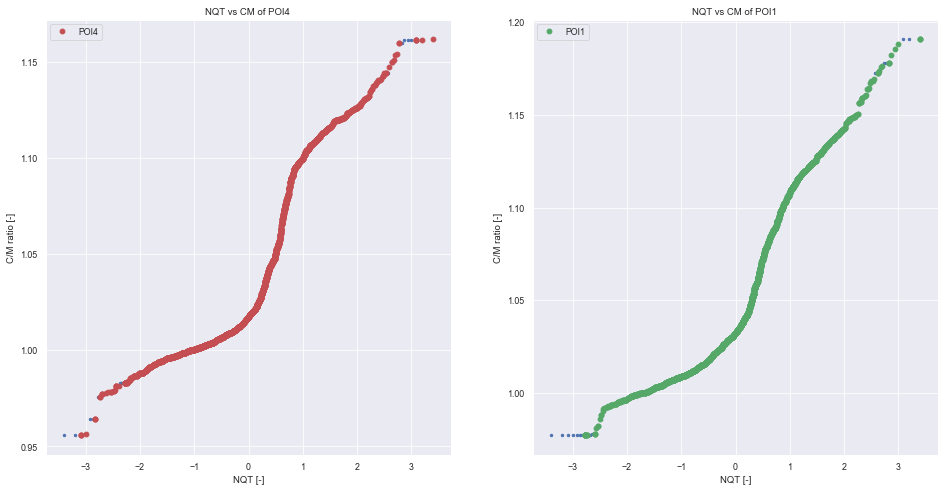

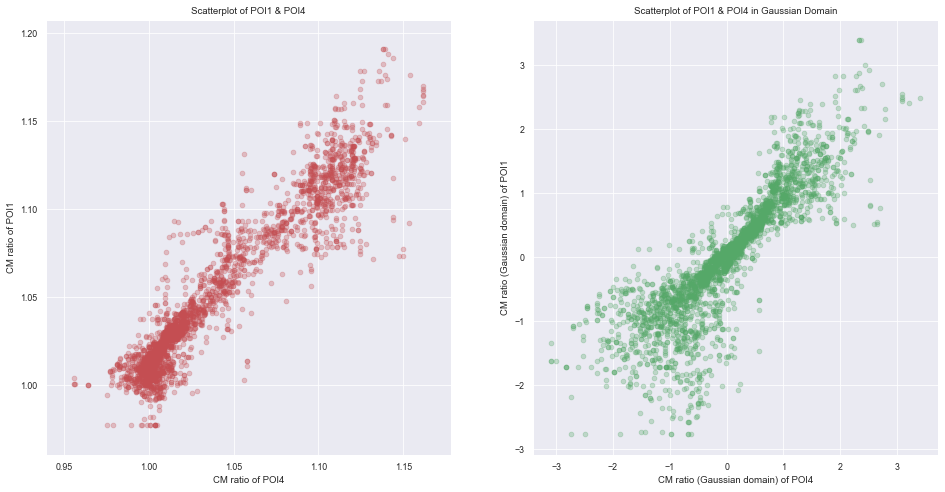

In [763]:
# Now calculating the NQT values for the actual AMSR-E data

mapping_cm_to_nqt_POI4 = interp.interp1d(np.sort(samples_Senanga_POI4), nqt_Senanga)#,fill_value="extrapolate")
mapping_cm_to_nqt_POI1 = interp.interp1d(np.sort(samples_Senanga_POI1), nqt_Senanga)#,fill_value="extrapolate")

nqt_mapped_POI4 = mapping_cm_to_nqt_POI4(samples_Senanga_POI4)
nqt_mapped_POI1 = mapping_cm_to_nqt_POI1(samples_Senanga_POI1)

sns.set_context("paper")
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)

plt.plot(nqt_Senanga, np.sort(samples_Senanga_POI4), '.')  
plt.plot(nqt_mapped_POI4, samples_Senanga_POI4, 'r.', label = 'POI4') 
plt.title('NQT vs CM of POI4 ')
plt.xlabel('NQT [-]')
plt.ylabel('C/M ratio [-]')
plt.legend()

plt.subplot(1,2,2)
plt.plot(nqt_Senanga, np.sort(samples_Senanga_POI1), '.')  
plt.plot(nqt_mapped_POI1, samples_Senanga_POI1, 'g.', label = 'POI1') 
plt.title('NQT vs CM of POI1 ')
plt.xlabel('NQT [-]')
plt.ylabel('C/M ratio [-]')
plt.legend()


plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(samples_Senanga_POI4,samples_Senanga_POI1,alpha=0.3, color='r')
plt.title('Scatterplot of POI1 & POI4')
plt.xlabel('CM ratio of POI4')
plt.ylabel('CM ratio of POI1')



plt.subplot(1,2,2)
plt.scatter(nqt_mapped_POI4,nqt_mapped_POI1,alpha=0.3, color='g')
plt.title('Scatterplot of POI1 & POI4 in Gaussian Domain')
plt.xlabel('CM ratio (Gaussian domain) of POI4')
plt.ylabel('CM ratio (Gaussian domain) of POI1')


df_nqt =pd.DataFrame({'POI1': nqt_mapped_POI1, 'POI4': nqt_mapped_POI4},index=df.index)


Gaussian Domain:


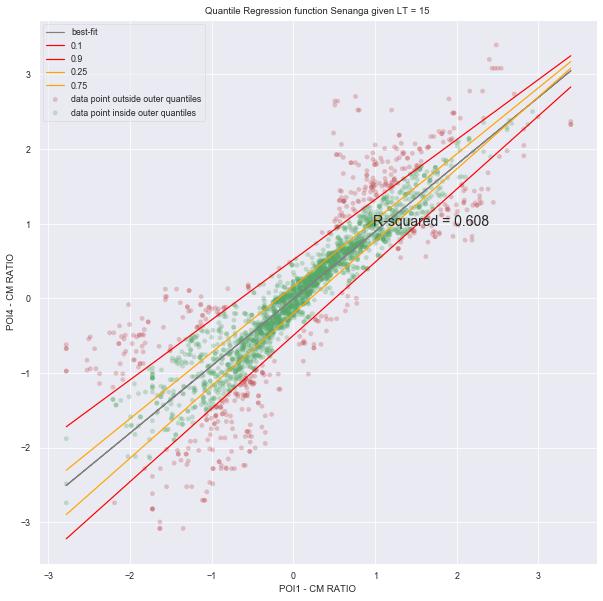

([<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x161a01790>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x16241f400>)

normal Domain:


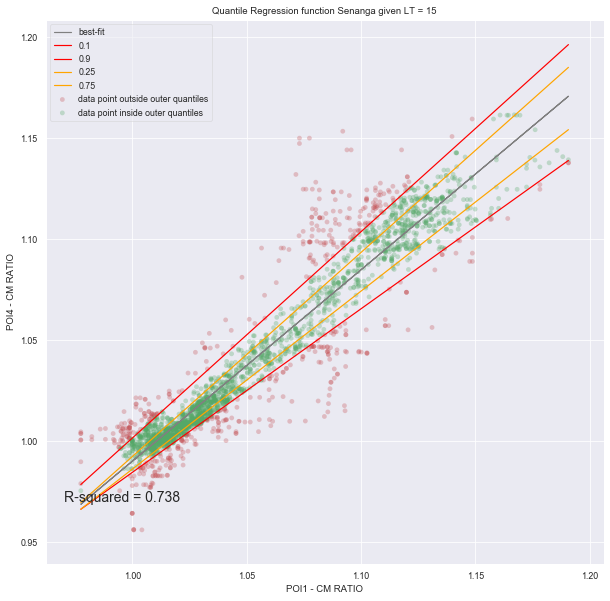

([<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1626b9b20>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1626b9850>)

In [766]:

plot=1
selection=12 #number of months to be taken into account. Change to set data to the rain season
print('Gaussian Domain:')
calculateQR(df_nqt,selection,plot,shift,location) #Quantile Regression plot with lines (Normal Quantile Transformed data)
print('Normal Domain:')
calculateQR(df,selection,plot,shift,location) #Quantile Regression plot with lines (Normal data)

